In [2]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re
import seaborn as sns

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABELCOLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABELCOLORSWOUTNOFINDING = LABELCOLORS[:8]+LABELCOLORS[9:]

In [3]:
coco = COCO('../dataset/train.json')
train_df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(ann_ids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


# Annotation Per Images
* 한 이미지에 몇 개의 Bounding box가 있는지, 그 분포를 나타낸 결과입니다.

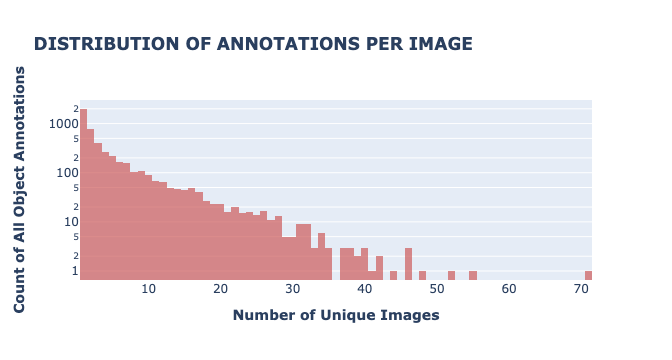

In [27]:
fig = px.histogram(train_df.image_id.value_counts(),
                    log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                    labels={"value":"Number of Annotations Per Image"},
                    title="<b>DISTRIBUTION OF ANNOTATIONS PER IMAGE"
                    )

fig.update_layout(showlegend=False,
                    xaxis_title="<b>Number of Unique Images</b>",
                    yaxis_title="<b>Count of All Object Annotations</b>",)

fig.show()

# Unique Class Per Image
* 한 이미지의 몇 개의 unique한 class가 있는지, 그 분포를 나타낸 결과입니다.

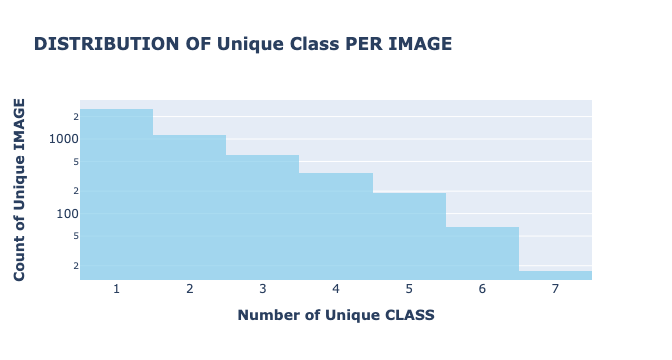

In [40]:
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)),
                log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
                labels={"value":"Number of Unique class"},
                title="<b>DISTRIBUTION OF Unique Class PER IMAGE"
            )

fig.update_layout(showlegend=False,
        xaxis_title="<b>Number of Unique CLASS</b>",
        yaxis_title="<b>Count of Unique IMAGE</b>",)

fig.show()

# Annotations Per Class
* 각 Class 당 몇 개의 Annotation, 즉 bbox가 있는지, 그 분포를 나타낸 결과입니다.

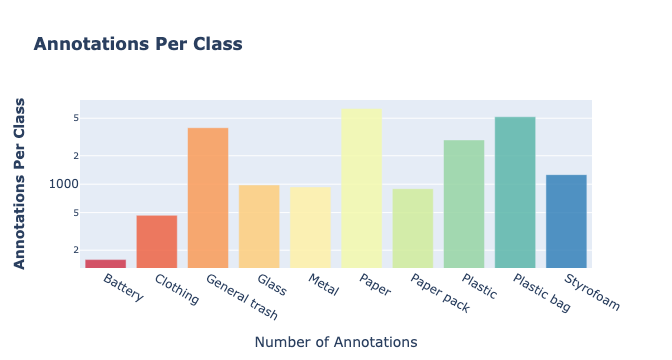

In [46]:
fig = px.bar(train_df.class_name.value_counts().sort_index(),
    color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
    color_discrete_sequence=LABELCOLORS, log_y=True,
    labels={"y":"Annotations Per Class", "x":""},
    title="<b>Annotations Per Class</b>",)

fig.update_layout(showlegend=False,
    xaxis_title="Number of Annotations",
    yaxis_title="<b>Annotations Per Class</b>")

fig.show()

In [4]:
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values
bbox_df['x_max'] = train_df['x_max'].values
bbox_df['y_min'] = train_df['y_min'].values
bbox_df['y_max'] = train_df['y_max'].values
bbox_df["bbox_area"] = (bbox_df["x_max"]-bbox_df["x_min"])*(bbox_df["y_max"]-bbox_df["y_min"])
bbox_df["bbox_oneside_size"] = np.sqrt((bbox_df["x_max"]-bbox_df["x_min"])*(bbox_df["y_max"]-bbox_df["y_min"]).values)
bbox_df["aspect_ratio"] = (bbox_df["x_max"]-bbox_df["x_min"])/(bbox_df["y_max"]-bbox_df["y_min"])

# Anchor Box 한 쪽 변 size 분석

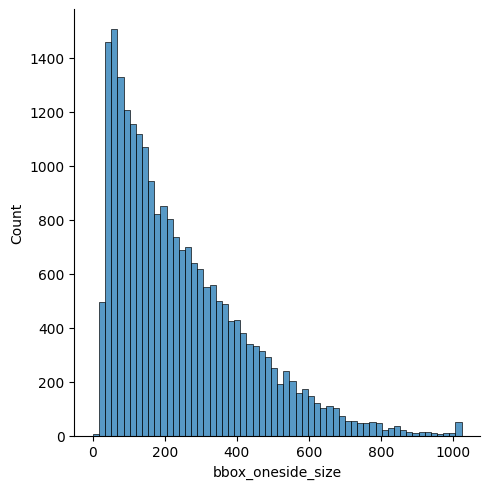

In [5]:
sns.displot(bbox_df['bbox_oneside_size'])

<AxesSubplot:>

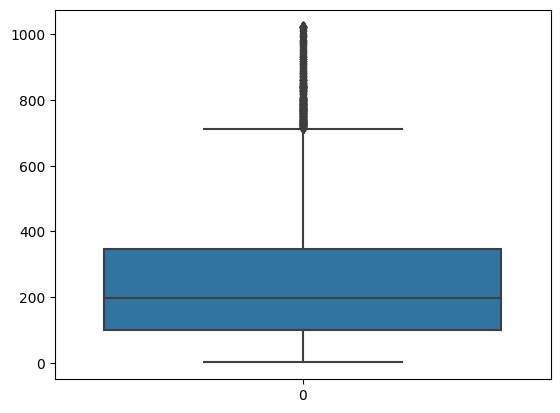

In [6]:
sns.boxplot(bbox_df['bbox_oneside_size'])

In [7]:
bbox_df['bbox_oneside_size'].describe

<bound method NDFrame.describe of 0        507.249110
1        101.992941
2        162.047400
3        262.861503
4        155.449606
            ...    
23139    876.693681
23140    239.394486
23141     42.103919
23142    230.236118
23143    386.824534
Name: bbox_oneside_size, Length: 23144, dtype: float64>

In [8]:
# 크기 순으로 나열 했을 때 하위 1%에 있는 수
np.percentile(bbox_df[["bbox_oneside_size"]].values, 10)

55.98231845620479

In [11]:
# 크기 순으로 나열 했을 때 상위 10%에 있는 수
np.percentile(bbox_df[["bbox_oneside_size"]].values, 60)

249.06779653204023

* 95% 이상이 한 변의 길이가 40 이상 임
* 95% 이상이 한 변의 길이가 600 이하임
* boxplot보면 대부분의 수치가 99~345 사이에 있음

# Anchor Box aspect ratio 분석

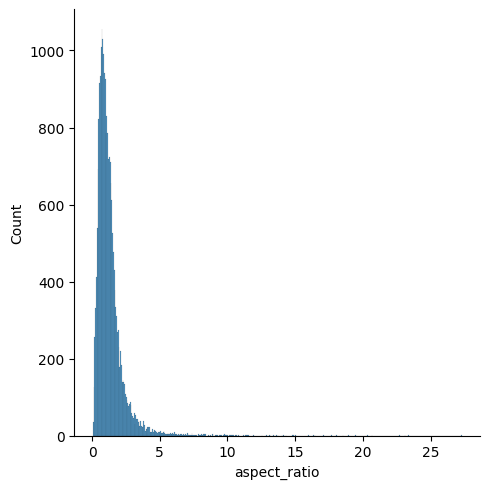

In [19]:
sns.displot(bbox_df['aspect_ratio'])

<AxesSubplot:>

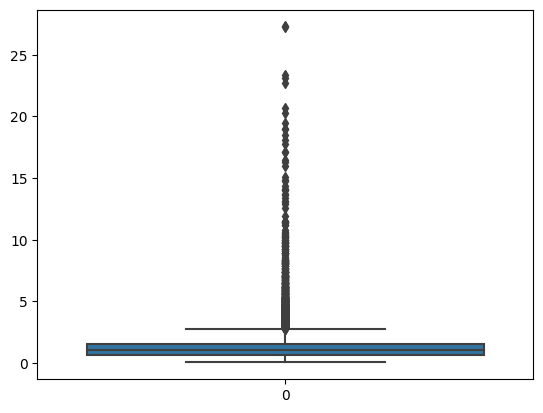

In [23]:
sns.boxplot(bbox_df['aspect_ratio'])

In [18]:
bbox_df['aspect_ratio'].describe()

count    23144.000000
mean         1.298707
std          1.166790
min          0.055391
25%          0.691147
50%          1.047518
75%          1.537306
max         27.285714
Name: aspect_ratio, dtype: float64

In [41]:
# 크기 순으로 나열 했을 때 하위 5%에 있는 수
np.percentile(bbox_df[["aspect_ratio"]].values, 5)

0.3515557551712947

In [14]:
# 크기 순으로 나열 했을 때 상위 10%에 있는 수
np.percentile(bbox_df[["aspect_ratio"]].values, 95)

2.9712146739130425

* 95% 이상이 0.35 이상 임
* box plot 을 보면 4분위 이상인 이상치들이 엄청 많음
* 90% 이상이  2.2 이하임
* boxplot보면 대부분의 수치가 0.7~1.5 사이에 있음

48, 100, 200, 350, 512

0.5, 1, 1.5 ,2